In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from numpy import random
from fastai.imports import *
import zipfile, kaggle, torch
import numpy as np, pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import seaborn as sns

In [2]:
np.set_printoptions(linewidth=130)

## 1. Introdução

O tema da aula 6 é *Random Forests*, e nesse artigo vamos aprender o que são, como criá-las, e como interpretá-las.

## 2. Objetivo

Entender os passos necessários para criar uma *random forest* e colocá-los em prática. 

## 3. Inspiração



## 4. Execução

### 4.1 

In [3]:
df = pd.read_csv('Social_Network_Ads.csv')
df

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
...,...,...,...
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0


In [4]:
df.loc[df['Age'].idxmax()]

Age                    60
EstimatedSalary    108000
Purchased               1
Name: 215, dtype: int64

In [5]:
df.loc[df['Age'].idxmin()]

Age                   18
EstimatedSalary    82000
Purchased              0
Name: 14, dtype: int64

In [6]:
df['Aged_18_to_38'] = df['Age'].between(18,38)
df['Aged_18_to_38'] = df['Aged_18_to_38'].astype(int)
df

,Age,EstimatedSalary,Purchased,Aged_18_to_38
0,19,19000,0,1
1,35,20000,0,1
2,26,43000,0,1
3,27,57000,0,1
4,19,76000,0,1
...,...,...,...,...
395,46,41000,1,0
396,51,23000,1,0
397,50,20000,1,0
398,36,33000,0,1


In [7]:
df.describe()

,Age,EstimatedSalary,Purchased,Aged_18_to_38
count,400.000000,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500,0.557500
std,10.482877,34096.960282,0.479864,0.497305
min,18.000000,15000.000000,0.000000,0.000000
25%,29.750000,43000.000000,0.000000,0.000000
50%,37.000000,70000.000000,0.000000,1.000000
75%,46.000000,88000.000000,1.000000,1.000000
max,60.000000,150000.000000,1.000000,1.000000


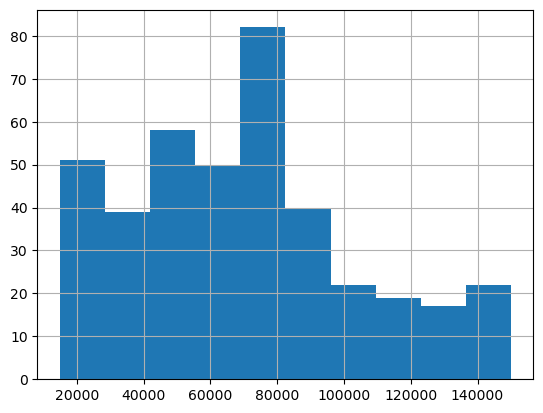

In [8]:
df['EstimatedSalary'].hist();

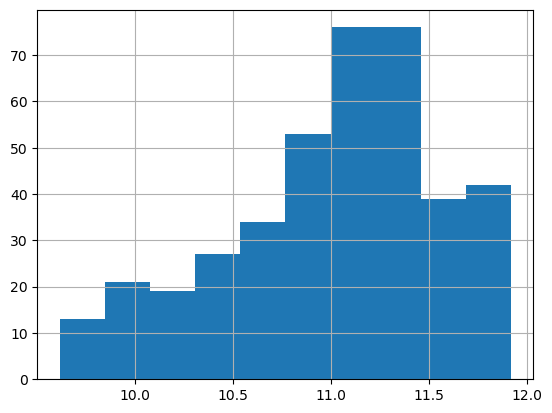

In [9]:
df['LogSalary'] = np.log(df['EstimatedSalary']+1)
df['LogSalary'].hist();

In [10]:
df.drop(['Age', 'EstimatedSalary'], axis=1 ,inplace=True)
df.head()

,Purchased,Aged_18_to_38,LogSalary
0,0,1,9.852247
1,0,1,9.903538
2,0,1,10.668979
3,0,1,10.950824
4,0,1,11.238502


### *Binary splits*

In [11]:
cat= ['Aged_18_to_38',]
cont = ['LogSalary',]
dep = 'Purchased'

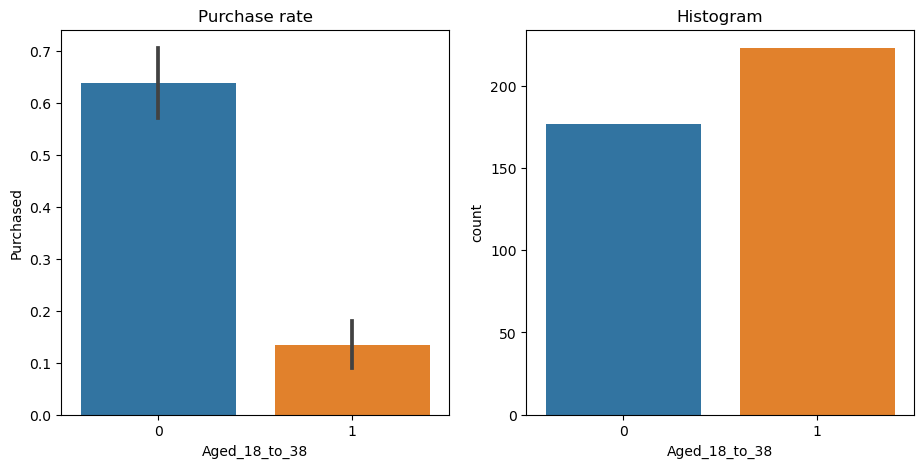

In [12]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Aged_18_to_38", ax=axs[0]).set(title="Purchase rate")
sns.countplot(data=df, x="Aged_18_to_38", ax=axs[1]).set(title="Histogram");

In [13]:
trn_df,val_df = train_test_split(df, test_size=0.25)

In [14]:
def xs_y(df):
    xs = df[cat+cont].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [15]:
preds = val_xs.Aged_18_to_38==0

In [16]:
mean_absolute_error(val_y, preds)

0.31

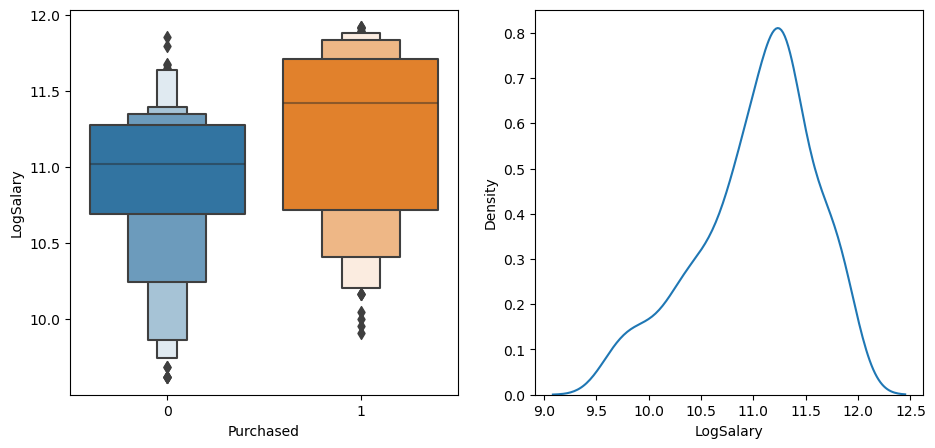

In [17]:
df_salary = trn_df[trn_df.LogSalary>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_salary, x=dep, y="LogSalary", ax=axs[0])
sns.kdeplot(data=df_salary, x="LogSalary", ax=axs[1]);

In [18]:
preds = val_xs.LogSalary>11.2
mean_absolute_error(val_y, preds)

0.32

In [19]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [20]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [21]:
score(trn_xs["Aged_18_to_38"], trn_y, 0.5)

0.3898149648530516

In [22]:
score(trn_xs["LogSalary"], trn_y, 11.2)

0.45432394403887144

In [25]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

In [24]:
cols = cat+cont
{o:min_col(trn_df, o) for o in cols}

{'Aged_18_to_38': (0, 0.3898149648530516),
 'LogSalary': (11.407576060361786, 0.4049860811301728)}

### Decision Tree

In [26]:
cols.remove("Aged_18_to_38")
is_young = trn_df.Aged_18_to_38==1
young,old = trn_df[is_young],trn_df[~is_young]

In [27]:
{o:min_col(young, o) for o in cols}

{'LogSalary': (11.407576060361786, 0.18203793114780933)}

In [28]:
{o:min_col(old, o) for o in cols}

{'LogSalary': (11.289794413577894, 0.41919114340423574)}

In [29]:
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [30]:
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

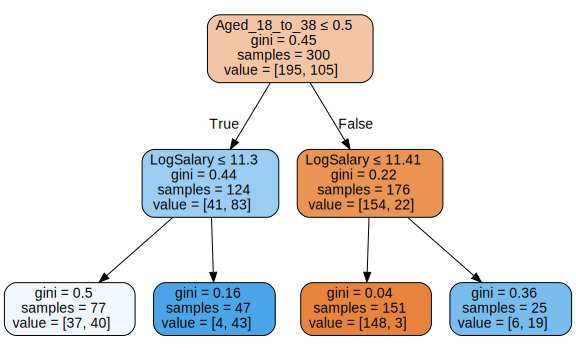

In [31]:
draw_tree(m, trn_xs, size=10)

In [32]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [35]:
gini(df.Aged_18_to_38==1), gini(df.Aged_18_to_38==0)

(0.2328621126505661, 0.4616808707587219)

In [36]:
mean_absolute_error(val_y, m.predict(val_xs))

0.24

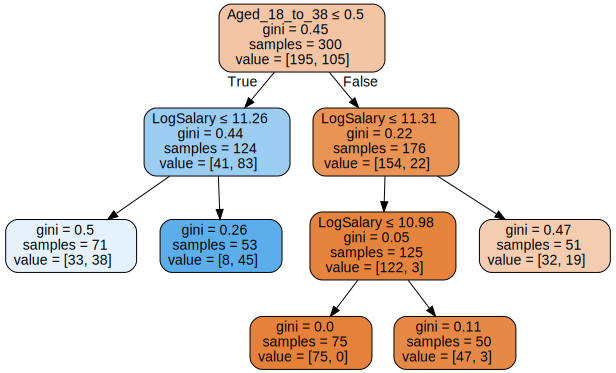

In [37]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [38]:
mean_absolute_error(val_y, m.predict(val_xs))

0.31

### Random Forest

In [150]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice([n-1, int(n*prop)])
    x = trn_xs.iloc[idxs]
    y = trn_y.iloc[idxs]
    return DecisionTreeClassifier(min_samples_leaf=5).fit(x, y)

In [151]:
trees = [get_tree() for t in range(100)]

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.       11.472114].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.